# Setting the values for constants
* inf: as a default distance to nodes
* time_threshold: threshold time for the rebuilding of the quantum link
* original_capacity: original capacity of the quantum link
* original_cost: cost of using the link
* Edge: create Edge object of the graph

In [140]:
inf = float('inf')
time_threshold = 10000
original_capacity = 4
original_cost = 1
rebuild_probability = 0.25
number_of_nodes = 32

In [141]:
# Importing packages
import os
from collections import deque, namedtuple
import time, random, logging, logging.handlers
from datetime import datetime

# Setting up logging
logging.basicConfig(filename='dijkstra.log',level=logging.DEBUG,
                    filemode='w')

# The Graph class

In [152]:
# Edge object of a graph
Edge = namedtuple('edge', 'start, end, cost, capacity')

# Method adding an edge in the graph
def make_edge(start, end, cost=original_cost, capacity=original_capacity):
    return Edge(start, end, cost, capacity)

def make_backward_edge(start, end, cost=original_cost, capacity=original_capacity):
    return Edge(end, start, cost, capacity)

In [153]:
class Graph:

    # Check that the arguments are valid
    def __init__(self, edges):
        wrong_edges = [i for i in edges if len(i) not in [2, 4]]
        if wrong_edges:
            raise ValueError('Wrong edges data: %s', wrong_edges)

        self.edges = [ make_edge(*Edge) for Edge in edges] + [make_backward_edge(*edge) for edge in edges]

    # Properties of the class
    @property
    def vertices(self):
        return set(
            sum(
                ([this_edge.start, this_edge.end] for this_edge in self.edges), []
            )
        )

    @property
    def neighbours(self):
        neighbours = {vertex: set() for vertex in self.vertices}
        for this_edge in self.edges:
            neighbours[this_edge.start].add((this_edge.end, this_edge.cost))

        return neighbours

    # Get current capacity of a specific link
    def link_capacity(self, startNode, endNode):

        # Assembling node pairs into a list
        node_pairs = [[startNode, endNode], [endNode, startNode]]
        edges = self.edges[:]
        for this_edge in edges:
            if [this_edge.start, this_edge.end] in node_pairs:
                return this_edge.capacity
    
    # Adds a link to the network specified by a pair of nodes, the cost and the capacity
    # Assembling node pairs into a list
    def add_link(self, startNode, endNode, cost=original_cost, capacity=original_capacity):

        node_pairs = [[startNode, endNode], [endNode, startNode]]
        edges = self.edges[:]
        for this_edge in edges:
            if [this_edge.start, this_edge.end] in node_pairs:
                self.edges.remove(this_edge)

                #Add bidirectional link
                self.edges.append(Edge(startNode, endNode, cost, capacity))
                self.edges.append(Edge(endNode, startNode, cost, capacity))

    def rebuild_link(self, startNode, endNode, cost=original_cost, capacity=original_capacity):
        sleep(time_threshold)
        self.add_link(startNode, endNode, cost, capacity)
        logging.debug('Link between %s and %s has been rebuilt.', startNode, endNode)

    # Remove a link specified by the start and end node
    def remove_link(self, startNode, endNode):
        
        node_pairs = [[startNode, endNode], [endNode, startNode]]
        edges = self.edges[:]
        for this_edge in edges:
            if [this_edge.start, this_edge.end] in node_pairs:
                
                self.edges.remove(this_edge)
                self.edges.append(make_edge(this_edge.start, this_edge.end,this_edge.cost,this_edge.capacity-1))

    # Processes a source-destination pair of distance one of the current path
    # by checking the capacity of the link between the start and the end node
    #
    # If the capacity is 0, then a probabilistic rebuild approach is used
    #
    # Returns the elapsed time that was needed to process the particular source-destination pair
    def process_step(self, startNode, endNode):

        local_edt = 0
        # If the capacity of the link is 0, then
        # do probabilistic rebuilding
        # 
        # Else: 
        # Consumes a link from the remaining ones
        # Alternatively: add the threshold waiting time for rebuilding
        if self.link_capacity(startNode,endNode) == 0:
            
            #Probabilistic link creation
            while(rebuild_probability*100<random.randint(1,100)):
                local_edt += 1
        else:
            
            #Remove the link between startNode and endNode
            self.remove_link(startNode,endNode)
            
            #Incrementing the entanglement delay time
            local_edt += 1
        
        return local_edt

    # Works through a source-destination pair by traversing through the nodes in between and adding the elapsed time
    #
    # Calls on the process_step method as many times as big the distance between the source and the destination is
    def process_path(self, currentPath):
        
        logging.debug('current path: %s', currentPath)
        
        #Initializing entanglement delay time
        edt = 0
        
        #Take the leftmost two nodes out of the deque and get the edt until we are finished
        while True:
            startNode = currentPath.popleft()
            endNode = currentPath.popleft()
            edt += self.process_step(startNode,endNode)
            currentPath.appendleft(endNode)
            if (len(currentPath))==1:     
                return edt

    # Method calculating the shortest path Dijkstra algorithm from a given source node to the destination
    def dijkstra(self, source, dest):
        
        #Checking if the given source is existing or not
        #assert source in self.vertices, 'Such source node doesn\'t exist'

        #Running the Initialize-Single-Source procedure
        distances = {vertex: inf for vertex in self.vertices}
        previous_vertices = {
            vertex: None for vertex in self.vertices
        }
        distances[source] = 0
        vertices = self.vertices.copy()

        #picking each vertex out of the min-priority deque
        while vertices:
            current_vertex = min(
                vertices, key=lambda vertex: distances[vertex])
            vertices.remove(current_vertex)
            
            #Relaxation procedure
            if distances[current_vertex] == inf:
                break
            for neighbour, cost in self.neighbours[current_vertex]:
                alternative_route = distances[current_vertex] + cost
                if alternative_route < distances[neighbour]:
                    distances[neighbour] = alternative_route
                    previous_vertices[neighbour] = current_vertex

        path, current_vertex = deque(), dest
        while previous_vertices[current_vertex] is not None:
            path.appendleft(current_vertex)
            current_vertex = previous_vertices[current_vertex]
        if path:
            path.appendleft(current_vertex)
        return path

In [194]:
# Generates random source-destination pairs
# The number of source-destination pairs is given by the argument
def gen_rand_pairs(number_of_pairs):
    result = []
    for x in range(number_of_pairs):
        source = random.randint(1,number_of_nodes)
        dest = random.randint(1,number_of_nodes)
        while source == dest:
            dest = random.randint(1,number_of_nodes)
        result += [[source,dest]]
    return result

# Generates source-destination pairs and finds the nodes in between them by calling on the dijkstra method
def initialize_paths(graph, number_of_source_destination_pairs):

    #Generate random pairs of nodes between which we are seeking a path
    randPairs = gen_rand_pairs(number_of_source_destination_pairs)
    #print(randPairs)
    
    #Assemble paths into one deque
    paths = deque()
    for pair in randPairs:
        paths.appendleft(graph.dijkstra(pair[0],pair[1]))
    return paths

# Sending packets based on the generated source destination pairs
# Processes these pairs by calling the process_path method on the next path
# Processes each of the paths stored in the deque and pushes the result edt into a store
def send_packets(graph, paths):

    edt_store = []

    while True:

        #Process the next path in the deque
        currentPath = paths.popleft()
        logging.debug('current method: send_packets')
        edt_store.append(graph.process_path(currentPath))
        if(len(paths)==0):
            return edt_store
        
def main(graph, number_of_source_destination_pairs):
    
    start = time.time()
    path_store = initialize_paths(graph, number_of_source_destination_pairs)
    
    # Storing the distances of the paths
    distance_store = []
    for x in path_store:
        distance_store.append(len(x))
    # Calculating the entanglement delay times
    edts = send_packets(graph, path_store)
    
    
    end = time.time()  
    logging.debug("Total time: %s", (end - start))
    logging.debug(graph.edges)
    return [edts,distance_store]

# Graph definitions

### Graph 1

In [195]:
graph1 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)]
)

#The edges created for the first graph:
print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph1.edges])

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (1, 32)]


### Graph 2

In [196]:
graph2 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)] +

    #Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    #Odd number of nodes  
    [(x,x+2) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +
    
    #Even number of nodes
    [(x,(x+2) % number_of_nodes) for x in range(1,number_of_nodes+1) if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0]
)

#The edges created for the second graph:
print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph2.edges])

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 1), (1, 3), (3, 5), (5, 7), (7, 9), (9, 11), (11, 13), (13, 15), (15, 17), (17, 19), (19, 21), (21, 23), (23, 25), (25, 27), (27, 29), (29, 31), (31, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (1, 32), (3, 1), (5, 3), (7, 5), (9, 7), (11, 9), (13, 11), (15, 13), (17, 15), (19, 17), (21, 19), (23, 21), (25, 23), (27, 25), (29, 27), (31, 29), (1, 31)]


### Graph 3

In [197]:
graph3 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)] +

    #Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    
    #Even number of nodes
    [(x,(x+2) % number_of_nodes) for x in range(1,number_of_nodes+1)
                                 if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0] +
        
    #Odd number of nodes  
    [(x,x+2) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +
        
    #Iniating the edges of 2) type: 1->5, 5->9, ... 29->1
    #Number of nodes have 0 as remainder for modulo 4  
    [(x,x+4) for x in range(1,number_of_nodes-3) if x % 4 == 1 and number_of_nodes % 4 == 0] + [(number_of_nodes-3,1) for x in range(1,2) if number_of_nodes % 4 == 0]
    
)

#The edges created for the third graph:
print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph3.edges])

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 1), (1, 3), (3, 5), (5, 7), (7, 9), (9, 11), (11, 13), (13, 15), (15, 17), (17, 19), (19, 21), (21, 23), (23, 25), (25, 27), (27, 29), (29, 31), (31, 1), (1, 5), (5, 9), (9, 13), (13, 17), (17, 21), (21, 25), (25, 29), (29, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (1, 32), (3, 1), (5, 3), (7, 5), (9, 7), (11, 9), (13, 11), (15, 13), (17, 15), (19, 17), (21, 19), (23, 21), (25, 23), (27, 25), (29, 27), (31, 29), (1, 31), (5, 1), (9, 5), (13, 

In [198]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def loop_main(graph, number):
    avg_edts = []
    for x in range(1, number+1):
        [edts, distances] = main(graph, x)
        avg_edts.append(mean(edts))
    return [avg_edts, distances]

# Define the number of source destination pairs

In [199]:
number_of_sd_pairs = 50

# Plotting the results

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt

### Calculating average edts and distances

In [201]:
[avg_edts1, distances1] = loop_main(graph1, number_of_sd_pairs)
[avg_edts2, distances2] = loop_main(graph2, number_of_sd_pairs)
[avg_edts3, distances3] = loop_main(graph3, number_of_sd_pairs)

### Plotting the edt results of the three graphs

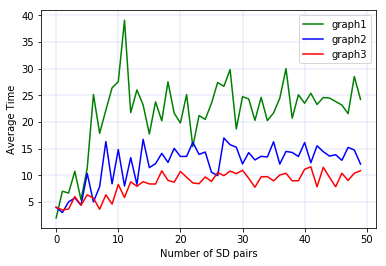

In [202]:
plt.plot(avg_edts1,color='green', label="graph1")
plt.plot(avg_edts2, color='blue', label="graph2")
plt.plot(avg_edts3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Average Time')
plt.legend()
plt.show()

### Plotting the distances for each number of source-destination pairs

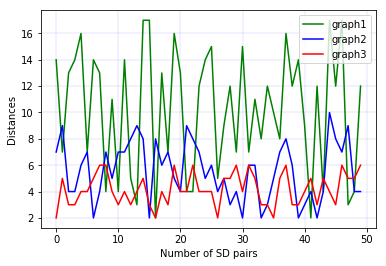

In [193]:
plt.plot(distances1,color='green', label="graph1")
plt.plot(distances2, color='blue', label="graph2")
plt.plot(distances3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Distances')
plt.legend()
plt.show()